# http://blog.wouterkoolen.info/GDasEW/post.html

In [1]:
import os, sys
import numpy as np
import json
import random
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import linalg as LA
from scipy.stats import entropy
import math

In [2]:
torch.manual_seed(12345)
k = 10000
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))
encoding_style = 'clipped'

In [3]:
# Original BLOSUM62 matrix
original_blosum62 = {}
with open('../blosum62.txt', 'r') as f:
    for line in f:
        split_line = line.strip().split()
        aa = split_line[0]
        encoding = [int(x) for x in split_line[1:-3]]
        original_blosum62[aa] = encoding
blosum_matrix = np.zeros((20, 20))
for i, aa in enumerate(original_blosum62.keys()):
    sims = original_blosum62[aa]
    for j, s in enumerate(sims):
        blosum_matrix[i][j] = s   
u, V = LA.eig(blosum_matrix)
clipped_u = u
clipped_u[clipped_u < 0] = 0
lamb = np.diag(clipped_u)
T = V
clip_blosum62 = {}
for i, aa in enumerate(original_blosum62.keys()):
    clip_blosum62[aa] = np.dot(np.sqrt(lamb), V[i])

## Model

In [4]:
# Expects peptides to be encoding according to BLOSUM62 matrix
# Expects aptamers to be one hot encoded
class BlosumNet(nn.Module):
    def __init__(self):
        super(BlosumNet, self).__init__()
        self.name = "BlosumNet"
        self.single_alphabet = False
        
        self.cnn_apt_1 = nn.Conv1d(4, 25, 3, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(25, 50, 3, padding=2) 
        self.cnn_apt_3 = nn.Conv1d(50, 25, 3, padding=2) 
        self.cnn_apt_4 = nn.Conv1d(25, 10, 3) 
        
        # There are 20 channels
        self.cnn_pep_1 = nn.Conv1d(20, 40, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(40, 80, 3, padding=2)
        self.cnn_pep_3 = nn.Conv1d(80, 150, 3, padding=2)
        self.cnn_pep_4 = nn.Conv1d(150, 50, 3, padding=2)
        self.cnn_pep_5 = nn.Conv1d(50, 10, 3, padding=2)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(790, 500)
        self.fc2 = nn.Linear(500, 200)
        self.fc3 = nn.Linear(200, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [5]:
# Expects peptides to be encoding according to BLOSUM62 matrix
# Expects aptamers to be one hot encoded
class BlosumLinearNet(nn.Module):
    def __init__(self):
        super(BlosumLinearNet, self).__init__()
        self.name = "BlosumLinearNet"
        self.single_alphabet = False
        
        self.fc_apt_1 = nn.Linear(160, 200) 
        self.fc_apt_2 = nn.Linear(200, 250)
        self.fc_apt_3 = nn.Linear(250, 300)
        
        self.fc_pep_1 = nn.Linear(160, 200)
        self.fc_pep_2 = nn.Linear(200, 250)
        
        self.relu = nn.ReLU()
        
        self.fc_apt = nn.Sequential(self.fc_apt_1, self.fc_apt_2, self.fc_apt_3)
        self.fc_pep = nn.Sequential(self.fc_pep_1, self.fc_pep_2)
        
        self.fc1 = nn.Linear(550, 600)
        self.fc2 = nn.Linear(600, 1)
        
    def forward(self, apt, pep):
        apt = apt.reshape((-1, 1)).T
        pep = pep.view(-1, 1).T
        
        apt = self.fc_apt(apt)
        pep = self.fc_pep(pep)
        x = torch.cat((apt, pep), 1)
        x = self.fc2(self.fc1(x))
        x = torch.sigmoid(x)
        return x

In [6]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.name = "LinearNet"
        
        self.fc_apt_1 = nn.Linear(160, 200) 
        self.fc_apt_2 = nn.Linear(200, 250)
        self.fc_apt_3 = nn.Linear(250, 300)
        
        self.fc_pep_1 = nn.Linear(160, 200)
        self.fc_pep_2 = nn.Linear(200, 250)
        
        self.relu = nn.ReLU()
        
        self.fc_apt = nn.Sequential(self.fc_apt_1, self.fc_apt_2, self.fc_apt_3)
        self.fc_pep = nn.Sequential(self.fc_pep_1, self.fc_pep_2)
        
        self.fc1 = nn.Linear(550, 600)
        self.fc2 = nn.Linear(600, 1)
        
    def forward(self, apt, pep):
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        apt = self.fc_apt(apt)
        pep = self.fc_pep(pep)
        x = torch.cat((apt, pep), 1)
        x = self.fc2(self.fc1(x))
        x = torch.sigmoid(x)
        return x

In [7]:
def conv3x3(in_planes, out_planes, kernel_size=3, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=kernel_size, stride=1,
                     padding=kernel_size//2, bias=True)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, kernel_size=3, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, kernel_size=kernel_size, stride=stride)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.LeakyReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, kernel_size=kernel_size, stride=stride)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, kernel_size=3, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv1d(inplanes, planes, kernel_size=1, bias=True)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=kernel_size, stride=1,
                               padding=kernel_size//2, bias=True)
        self.bn2 = nn.BatchNorm1d(planes)
        self.conv3 = nn.Conv1d(planes, planes * 4, kernel_size=1, bias=True)
        self.bn3 = nn.BatchNorm1d(planes * 4)
        self.relu = nn.LeakyReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class VariableLengthPooling(nn.Module):
    def forward(self, x, **kwargs):
        bounds = kwargs.get("bounds")
        # print("--------x--------", x.size(), x)
        # print("--------bounds--------", bounds.size(), bounds)
        cnt = torch.sum(bounds, dim=1)
        # print("--------cnt--------", cnt.size(), cnt)
        # print("--------bmm--------", torch.bmm(x, bounds).size(), torch.bmm(x, bounds))
        out = torch.bmm(x, bounds) / cnt
        # print("--------out--------", out.size(), out)
        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=46):
        self.name = "Resnet"
        self.single_alphabet=True
        self.inplanes = 192
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv1d(48, 192, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn1 = nn.BatchNorm1d(192)
        self.relu = nn.LeakyReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 256, layers[0])
        self.layer1 = self._make_layer(block, 256, layers[0], kernel_size=1, stride=1)
        self.layer2 = self._make_layer(block, 256, layers[1], kernel_size=5, stride=1)
        self.layer3 = self._make_layer(block, 256, layers[2], kernel_size=5, stride=1)
        self.layer4 = self._make_layer(block, 512, layers[3], kernel_size=1, stride=1)
        self.layer5 = self._make_layer(block, 512, layers[3], stride=1)
        
        self.fc1 = nn.Linear(48, 1)

        self.conv_merge = nn.Conv1d(256 * block.expansion, num_classes,
                                    kernel_size=3, stride=1, padding=1,
                                    bias=True)
        self.vlp = VariableLengthPooling()
        # self.avgpool = nn.AvgPool2d((5, 1), stride=1)
        # self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.xavier_normal(m.weight.data)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, kernel_size=3, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=1, bias=False),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, kernel_size=kernel_size,
                            stride=stride, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, kernel_size=kernel_size))

        return nn.Sequential(*layers)


    def forward(self, x, bounds=None):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)

        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        # x = self.avgpool(x)
        # x = x.view(x.size(0), -1)
        # x = self.fc(x)

        x = self.conv_merge(x)
        x = torch.squeeze(x, dim=2)
        x = x.view(1, -1)
        
        
        # I don't think I want variable length pooling
        #x = self.vlp(x, bounds=bounds)
        x = self.fc1(x)
        return torch.sigmoid(x)

class ResNetSeparated(nn.Module):

    def __init__(self, block, layers, num_classes=46):
        self.name = "ResnetSeparated"
        self.single_alphabet=False
        self.inplanes = 192
        super(ResNetSeparated, self).__init__()
        self.conv1_apt = nn.Conv1d(4, 192, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv1_pep = nn.Conv1d(20, 192, kernel_size=3, stride=1, padding=1, bias=True)
        
        self.bn1 = nn.BatchNorm1d(192)
        self.relu = nn.LeakyReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 256, layers[0])
        self.layer1 = self._make_layer(block, 256, layers[0], kernel_size=1, stride=1)
        self.layer2 = self._make_layer(block, 256, layers[1], kernel_size=5, stride=1)
        #self.layer3 = self._make_layer(block, 256, layers[2], kernel_size=5, stride=1)
        #self.layer4 = self._make_layer(block, 512, layers[3], kernel_size=1, stride=1)
        #self.layer5 = self._make_layer(block, 512, layers[3], stride=1)
        
        self.fc1 = nn.Linear(96, 1)
        
        self.apt_initial = nn.Sequential(self.conv1_apt, self.bn1, self.relu)
        self.pep_initial = nn.Sequential(self.conv1_pep, self.bn1, self.relu)
        
        

        self.conv_merge = nn.Conv1d(256 * block.expansion, num_classes,
                                    kernel_size=3, stride=1, padding=1,
                                    bias=True)
        
        self.conv_layers = nn.Sequential(self.layer0, self.layer1, self.layer2,
                                         self.conv_merge)
        self.vlp = VariableLengthPooling()
        # self.avgpool = nn.AvgPool2d((5, 1), stride=1)
        # self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.xavier_normal(m.weight.data)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, kernel_size=3, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=1, bias=False),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, kernel_size=kernel_size,
                            stride=stride, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, kernel_size=kernel_size))

        return nn.Sequential(*layers)


    def forward(self, apt, pep, bounds=None):
        apt = self.apt_initial(apt)
        pep = self.pep_initial(pep)
        
        apt = self.conv_layers(apt)
        pep = self.conv_layers(pep)
        
        apt = torch.squeeze(apt, dim=2)
        pep = torch.squeeze(pep, dim=2)
        
        apt = apt.view(1, -1)
        pep = pep.view(1, -1)
        
        x = torch.cat((apt, pep), 1)
        
        # I don't think I want variable length pooling
        #x = self.vlp(x, bounds=bounds)
        x = self.fc1(x)
        return torch.sigmoid(x)

In [8]:
# Reinstantiate the model with the proper weights
model = BlosumNet()
model_name = model.name
model_id = "08042020_3"
model.to(device)
checkpointed_model = '../model_checkpoints/binary/%s/%s.pth' % (model_name, model_id)
checkpoint = torch.load(checkpointed_model)
#optimizer = SGD(model.parameters(), lr=7e-4)
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#init_epoch = checkpoint['epoch'] +1
model.eval()

BlosumNet(
  (cnn_apt_1): Conv1d(4, 25, kernel_size=(3,), stride=(1,), padding=(2,))
  (cnn_apt_2): Conv1d(25, 50, kernel_size=(3,), stride=(1,), padding=(2,))
  (cnn_apt_3): Conv1d(50, 25, kernel_size=(3,), stride=(1,), padding=(2,))
  (cnn_apt_4): Conv1d(25, 10, kernel_size=(3,), stride=(1,))
  (cnn_pep_1): Conv1d(20, 40, kernel_size=(3,), stride=(1,), padding=(2,))
  (cnn_pep_2): Conv1d(40, 80, kernel_size=(3,), stride=(1,), padding=(2,))
  (cnn_pep_3): Conv1d(80, 150, kernel_size=(3,), stride=(1,), padding=(2,))
  (cnn_pep_4): Conv1d(150, 50, kernel_size=(3,), stride=(1,), padding=(2,))
  (cnn_pep_5): Conv1d(50, 10, kernel_size=(3,), stride=(1,), padding=(2,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_apt): Sequential(
    (0): Conv1d(4, 25, kernel_size=(3,), stride=(1,), padding=(2,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv1d(25, 50, kerne

## SGD based search

In [9]:
# Encode the peptide appropriately
def blosum62_encoding(sequence, seq_type='peptide', single_alphabet=False, style=encoding_style):
    if single_alphabet:
        pass
    else:
        if seq_type == 'peptide':
            encoding = []
            for i in range(len(sequence)):
                if style == "clipped":
                    encoding.append(clip_blosum62[sequence[i]])
                else:
                    encoding.append(original_blosum62[sequence[i]])
            encoding = np.asarray(encoding)
        else:
            #Translation
            letters = na_list
            encoding = np.zeros(len(sequence))
            for i in range(len(sequence)):
                char = sequence[i]
                idx = letters.index(char)
                encoding[i] = idx
        return encoding 

## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide', single_alphabet=False):
    if single_alphabet:
        apt = sequence[0]
        pep = sequence[1]
        one_hot = np.zeros((len(apt) + len(pep), 24))
        # Encode the aptamer first
        for i in range(len(apt)):
            char = apt[i]
            for _ in range(len(na_list)):
                idx = na_list.index(char)
                one_hot[i][idx] = 1
            
        # Encode the peptide second
        for i in range(len(pep)):
            char = pep[i]
            for _ in range(len(aa_list)):
                idx = aa_list.index(char) + len(na_list)
                one_hot[i+len(apt)][idx] = 1
        
        return one_hot       
    else:
        if seq_type == 'peptide':
            letters = aa_list
        else:
            letters = na_list
        one_hot = np.zeros((len(sequence), len(letters)))
        for i in range(len(sequence)):
            char = sequence[i]
            for _ in range(len(letters)):
                idx = letters.index(char)
                one_hot[i][idx] = 1
        return one_hot
# Convert a pair to one-hot tensor
def convert(apt, pep, label, single_alphabet=False): 
    if single_alphabet:
        pair = translate([apt, pep], single_alphabet=True) #(2, 40)
        pair = torch.FloatTensor(np.reshape(pair, (-1, pair.shape[0], pair.shape[1]))).to(device)
        label = torch.FloatTensor([[label]]).to(device)
        return pair, label
    else:
        #pep = blosum62_encoding(pep, seq_type='peptide') Blosum encoding
        pep = one_hot(pep, seq_type='peptide')
        apt = torch.FloatTensor(np.reshape(apt, (-1, apt.shape[1], apt.shape[0]))).to(device) #(1, 4, 40)
        pep = torch.FloatTensor(np.reshape(pep, (-1, pep.shape[1], pep.shape[0]))).to(device) #(1, 20, 8)
        
        label = torch.FloatTensor([[label]]).to(device)
        return apt, pep, label

# Getting the output of the model for a pair (aptamer, peptide)
def update(x, y, p, single_alphabet=False):
    if single_alphabet:
        p.requires_grad=True
        p = p.to(device)
        out = model(p)
        return out
    else:
        x.requires_grad=True
        y.requires_grad=False
        x = x.to(device)
        y = y.to(device)
        out = model(x, y)
        return out

In [10]:
# Un one-hot the aptamer
def stringify(oh):
    # oh.shape = (1, 4, 40)
    aptamer_string = ""
    na_list = ['A', 'C', 'G', 'T']
    for i in range(40):
        column = oh[0, :, i]
        ind = np.argmax(column)
        aptamer_string += na_list[ind]
    return aptamer_string

In [11]:
# Round the resulting aptamer
def round_aptamer(apt):
    rounded_aptamer = np.zeros((1, 4, 40))
    for i in range(40):
        ind = np.argmax(apt[i, :, :])
        rounded_aptamer[0, ind, i] = 1
    return rounded_aptamer

In [12]:
def perturbed_uniform():
    aptamer_0 = np.full((40, 4), 0.25)
    for i in range(40):
        # Perturb this column 25% of the time
        if random.randint(0, 3) == 1:
            # Find an index to perturb
            inds = random.sample(range(0, 4), 2)
            ind_0 = inds[0]
            ind_1 = inds[1]
            
            # Find an amount to perturb
            amt = random.randint(0, 25)
            amt /= 100
            
            # Transaction
            aptamer_0[i][ind_0] = 0.25 + amt
            aptamer_0[i][ind_1] = 0.25 - amt
    
    return aptamer_0
            

In [13]:
def exponential_random_initialization():
    aptamer_0 = np.zeros((40, 4))
    for i in range(40):
        d = 4
        e = np.exp(np.random.rand(d))
        e /= np.sum(e)
        for j in range(4):
            aptamer_0[i][j] = e[j]
    return aptamer_0

In [52]:
def hill_climb(peptide, initial_aptamer_str, iterations=10):
    initial_aptamer = one_hot(initial_aptamer_str, seq_type='aptamer', single_alphabet=False)
    nucleotides = ['A', 'T', 'G', 'C']
    hill_climb_scores = []
    curr_aptamer = initial_aptamer
    curr_aptamer_str = initial_aptamer_str
    best_score = 0
    num_iter = 0
    
    # Go through the number of iterations
    for it in range(iterations):
        num_iter += 1
        updated = False
        
        # Get the initial score for this iteration
        a, p, l = convert(curr_aptamer, peptide, 1, single_alphabet=False)
        curr_best_score = update(a, p, 1, single_alphabet=False).item()
        curr_best_aptamer = curr_aptamer_str
        curr_apt = list(curr_aptamer_str)
        
        # For each position
        for i in range(40):
            for n in range(4):
                # Change one character
                test_apt = curr_apt.copy()
                test_apt[i] = nucleotides[n]
                test_apt_str = ''.join(test_apt)
                test_apt = one_hot(test_apt_str, seq_type='aptamer', single_alphabet=False)
                a, p, l = convert(test_apt, peptide, 1, single_alphabet=False)
                new_score = update(a, p, 1, single_alphabet=False)
                if new_score.item() > curr_best_score:
                    updated = True
                    curr_best_score = new_score.item()
                    curr_best_aptamer = test_apt_str
                    hill_climb_scores.append(new_score)
        
        # If we find that none of the changes increase the score, just stop
        if not updated:
            break
        
        # Updated the global best aptamer
        curr_aptamer_str = curr_best_aptamer
        best_score = curr_best_score
        curr_aptamer = one_hot(curr_aptamer_str, seq_type='aptamer', single_alphabet=False)
    print("Num Iterations: ", num_iter)
    
    return best_score, curr_aptamer

In [53]:
hill_climb_score, hill_climbed_aptamer = hill_climb("MMFKYRAP", "GCAAAAAGTCTACTTCTCCGTAACGGTAGGATACAGATCG", iterations=10000)
print("Hill climb score: ", hill_climb_score)

Num Iterations:  25
Hill climb score:  0.9094732999801636


## Use SGD to find an aptamer

In [54]:
def exponential_weights(peptide, actual_aptamer):
    # Initialization with exponential random nums
    peptide = "MMFKYRAP"
    actual_aptamer = "GCAAAAAGTCTACTTCTCCGTAACGGTAGGATACAGATCG"

    #aptamer_0 = one_hot(actual_aptamer, seq_type='aptamer')#exponential_random_initialization()
    aptamer_0 = exponential_random_initialization()
    curr_aptamer = aptamer_0

    lr = 5e-1
    scores = []
    for k in range(1000):
        a, p, l = convert(curr_aptamer, peptide, 1, single_alphabet=False)
        train_score = update(a, p, 1, single_alphabet=False)
        train_score.backward()
        scores.append(train_score.item())

        new_aptamer = np.zeros((40, 4, 1))
        # Looping over the indices
        for i in range(40):
            # Gradient for this position
            l_t = a.grad.cpu().numpy()
            l_t = l_t.reshape((40, 1, 4))[i]
            l_t = l_t[0]

            # Old probability distribution
            w = a.reshape((40, 1, 4))[i].cpu().detach().numpy()
            w = w[0]

            # New probability distribution
            denom = 0
            for j in range(4):            
                new_aptamer[i][j] = w[j]*np.exp(lr*l_t[j])
                denom += new_aptamer[i][j]
            for j in range(4):
                new_aptamer[i][j] = new_aptamer[i][j]/denom

        curr_aptamer = new_aptamer

    a, p, l = convert(curr_aptamer, peptide, 1, single_alphabet=False)
    unrounded_score = update(a, p, 1, single_alphabet=False)

    # Rounding Strategy # 1: Just max
    rounded_aptamer = round_aptamer(curr_aptamer)
    rounded_aptamer_str = stringify(rounded_aptamer)
    a, p, l = convert(rounded_aptamer, peptide, 1, single_alphabet=False)
    a = a.permute((2, 1, 0))
    max_rounded_score = update(a, p, None, single_alphabet=False)

    # Rounding Strategy #2: Hill climbing
    hill_climb_score, hill_climbed_aptamer = hill_climb(peptide, rounded_aptamer_str, iterations=100000)

    # Test the actual aptamer
    actual_aptamer_oh = one_hot(actual_aptamer, seq_type='aptamer')
    a, p, l = convert(actual_aptamer_oh, peptide, 1, single_alphabet=False)
    actual_score = update(a, p, None, single_alphabet=False)

    return unrounded_score, max_rounded_score, hill_climb_score, actual_score

In [51]:
peptide = "MMFKYRAP"
actual_aptamer = "GCAAAAAGTCTACTTCTCCGTAACGGTAGGATACAGATCG"
unrounded_score, max_rounded_score, hill_climb_score, actual_score = exponential_weights(peptide, actual_aptamer)
print("Unrounded: ", unrounded_score)
print("Max Rounded: ", max_rounded_score)
print("Hill Climb: ", hill_climb_score)
print("Actual Score: ", actual_score)

Unrounded:  tensor([[0.9052]], device='cuda:0', grad_fn=<SigmoidBackward>)
Max Rounded:  tensor([[0.5955]], device='cuda:0', grad_fn=<SigmoidBackward>)
Hill Climb:  0.930354654788971
Actual Score:  tensor([[0.3760]], device='cuda:0', grad_fn=<SigmoidBackward>)


## Finding out if we get optimal scores

In [57]:
with open('../../data/fw_pairs.txt') as f:
    optimal_count = 0
    unoptimal_count = 0
    found_scores = []
    actual_scores = []
    for i, pair in enumerate(tqdm.tqdm(f.readlines()[:50])):
        apt, pep = pair.split()
        unrounded_score, max_rounded_score, hill_climb_score, actual_score = exponential_weights(pep, apt)
        if hill_climb_score >= unrounded_score:
            optimal_count += 1
        else:
            unoptimal_count += 1
            print("Actual Score: " + str(actual_score) + "Found score: " + str(hill_climb_score))
        found_scores.append(hill_climb_score)
        actual_scores.append(unrounded_score.item())
print("Optimal Found: ", optimal_count)
print("Unoptimal Found: ", unoptimal_count)


  2%|▏         | 1/50 [00:14<11:42, 14.34s/it]

Num Iterations:  9


  4%|▍         | 2/50 [00:30<11:56, 14.93s/it]

Num Iterations:  15


  6%|▌         | 3/50 [00:46<12:00, 15.33s/it]

Num Iterations:  15


  8%|▊         | 4/50 [01:04<12:20, 16.10s/it]

Num Iterations:  20


 10%|█         | 5/50 [01:20<11:53, 15.86s/it]

Num Iterations:  12
Actual Score: tensor([[0.3760]], device='cuda:0', grad_fn=<SigmoidBackward>)Found score: 0.9165347218513489


 12%|█▏        | 6/50 [01:33<11:09, 15.21s/it]

Num Iterations:  7


 14%|█▍        | 7/50 [01:49<10:55, 15.24s/it]

Num Iterations:  12


 16%|█▌        | 8/50 [02:02<10:14, 14.64s/it]

Num Iterations:  4
Actual Score: tensor([[0.3760]], device='cuda:0', grad_fn=<SigmoidBackward>)Found score: 0.8825384378433228


 18%|█▊        | 9/50 [02:19<10:24, 15.24s/it]

Num Iterations:  12


 20%|██        | 10/50 [02:35<10:23, 15.58s/it]

Num Iterations:  13


 22%|██▏       | 11/50 [02:49<09:55, 15.27s/it]

Num Iterations:  8


 24%|██▍       | 12/50 [03:08<10:13, 16.13s/it]

Num Iterations:  22


 26%|██▌       | 13/50 [03:23<09:51, 16.00s/it]

Num Iterations:  15


 28%|██▊       | 14/50 [03:37<09:11, 15.33s/it]

Num Iterations:  13


 30%|███       | 15/50 [03:50<08:28, 14.52s/it]

Num Iterations:  9
Actual Score: tensor([[0.3760]], device='cuda:0', grad_fn=<SigmoidBackward>)Found score: 0.9034560918807983


 32%|███▏      | 16/50 [04:04<08:13, 14.50s/it]

Num Iterations:  15


 34%|███▍      | 17/50 [04:17<07:39, 13.92s/it]

Num Iterations:  7


 36%|███▌      | 18/50 [04:30<07:23, 13.85s/it]

Num Iterations:  7
Actual Score: tensor([[0.3760]], device='cuda:0', grad_fn=<SigmoidBackward>)Found score: 0.9064624309539795


 38%|███▊      | 19/50 [04:45<07:13, 13.98s/it]

Num Iterations:  11


 40%|████      | 20/50 [05:00<07:14, 14.50s/it]

Num Iterations:  17


 42%|████▏     | 21/50 [05:16<07:13, 14.95s/it]

Num Iterations:  16


 44%|████▍     | 22/50 [05:32<07:06, 15.23s/it]

Num Iterations:  15


 46%|████▌     | 23/50 [05:46<06:42, 14.90s/it]

Num Iterations:  9


 48%|████▊     | 24/50 [06:02<06:34, 15.17s/it]

Num Iterations:  15


 50%|█████     | 25/50 [06:18<06:24, 15.37s/it]

Num Iterations:  15


 52%|█████▏    | 26/50 [06:32<06:00, 15.00s/it]

Num Iterations:  9


 54%|█████▍    | 27/50 [06:47<05:42, 14.90s/it]

Num Iterations:  11
Actual Score: tensor([[0.3760]], device='cuda:0', grad_fn=<SigmoidBackward>)Found score: 0.9012414813041687


 56%|█████▌    | 28/50 [07:02<05:27, 14.90s/it]

Num Iterations:  14


 58%|█████▊    | 29/50 [07:16<05:09, 14.76s/it]

Num Iterations:  12
Actual Score: tensor([[0.3760]], device='cuda:0', grad_fn=<SigmoidBackward>)Found score: 0.898536741733551


 60%|██████    | 30/50 [07:33<05:09, 15.49s/it]

Num Iterations:  16


 62%|██████▏   | 31/50 [07:50<04:58, 15.73s/it]

Num Iterations:  17


 64%|██████▍   | 32/50 [08:03<04:31, 15.07s/it]

Num Iterations:  7
Actual Score: tensor([[0.3760]], device='cuda:0', grad_fn=<SigmoidBackward>)Found score: 0.9092848896980286


 66%|██████▌   | 33/50 [08:19<04:20, 15.32s/it]

Num Iterations:  12


 68%|██████▊   | 34/50 [08:35<04:09, 15.60s/it]

Num Iterations:  13


 70%|███████   | 35/50 [08:53<04:03, 16.22s/it]

Num Iterations:  16


 72%|███████▏  | 36/50 [09:11<03:55, 16.83s/it]

Num Iterations:  18


 74%|███████▍  | 37/50 [09:25<03:27, 16.00s/it]

Num Iterations:  8
Actual Score: tensor([[0.3760]], device='cuda:0', grad_fn=<SigmoidBackward>)Found score: 0.9096685647964478


 76%|███████▌  | 38/50 [09:43<03:18, 16.53s/it]

Num Iterations:  19


 78%|███████▊  | 39/50 [09:59<03:00, 16.41s/it]

Num Iterations:  13


 80%|████████  | 40/50 [10:16<02:44, 16.42s/it]

Num Iterations:  13


 82%|████████▏ | 41/50 [10:30<02:22, 15.83s/it]

Num Iterations:  9
Actual Score: tensor([[0.3760]], device='cuda:0', grad_fn=<SigmoidBackward>)Found score: 0.9036784172058105


 84%|████████▍ | 42/50 [10:46<02:07, 15.91s/it]

Num Iterations:  14


 86%|████████▌ | 43/50 [11:03<01:52, 16.10s/it]

Num Iterations:  16


 88%|████████▊ | 44/50 [11:16<01:32, 15.39s/it]

Num Iterations:  10
Actual Score: tensor([[0.3760]], device='cuda:0', grad_fn=<SigmoidBackward>)Found score: 0.9048740863800049


 90%|█████████ | 45/50 [11:30<01:13, 14.73s/it]

Num Iterations:  9


 92%|█████████▏| 46/50 [11:45<00:59, 14.84s/it]

Num Iterations:  16


 94%|█████████▍| 47/50 [11:58<00:43, 14.35s/it]

Num Iterations:  9
Actual Score: tensor([[0.3760]], device='cuda:0', grad_fn=<SigmoidBackward>)Found score: 0.9159601926803589


 96%|█████████▌| 48/50 [12:13<00:28, 14.42s/it]

Num Iterations:  14


 98%|█████████▊| 49/50 [12:28<00:14, 14.61s/it]

Num Iterations:  15


100%|██████████| 50/50 [12:44<00:00, 15.29s/it]

Num Iterations:  19
Optimal Found:  39
Unoptimal Found:  11


Text(0.5, 1.0, 'Results of the Exponential Weights Algorithm')

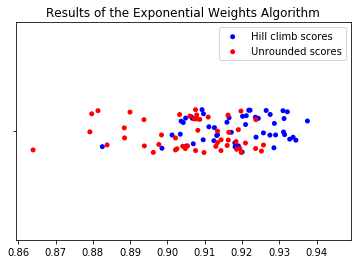

In [58]:
sns.stripplot(found_scores, color='blue', label='Hill climb scores')
sns.stripplot(actual_scores, color='red', label='Unrounded scores')
plt.legend()
plt.title("Results of the Exponential Weights Algorithm")